In [2]:
from typing import Dict, TypedDict, Optional

In [3]:
class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None

In [4]:
# !python -m pip install langgraph

In [5]:
from langgraph.graph import StateGraph, END

In [6]:
workflow = StateGraph(GraphState)

In [7]:
def classify(question):
    print(type(question))
    greet_list = ["hello", "good morning", "good evening", "hey"]
    for g in greet_list:
        if g in question:
            return "greeting"
    return "question"

def summarise(question):
    from transformers import pipeline
    summarizer = pipeline("summarization", model="google-t5/t5-small")
    summarised_text = summarizer(question)
    return {"summarised_text": summarised_text}


def classify_input_node(state):
    question = state.get('question', '').strip()
    classification = classify(question)
    return {"classification":classification}

def handle_greeting_node(state):
    return {"response": "Hello! How can I help you!"}

def handle_summarise_node(state):
    question = state.get('question', '').strip()
    summarise_result = summarise(question)
    return {"response": summarise_result}
    
def decide_next_node(state):
    return "handle_greeting" if state.get('classification') == "greeting" else "handle_summarise"


In [8]:
# Add nodes to the graph
workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
workflow.add_node("handle_summarise", handle_summarise_node)
workflow.add_conditional_edges("classify_input", decide_next_node,
                              {
                                  "handle_greeting": "handle_greeting",
                                  "handle_summarise": "handle_summarise"
                              }
                              )
#set entry points and define end points
workflow.set_entry_point("classify_input")
workflow.add_edge("handle_greeting", END)
workflow.add_edge("handle_summarise", END)

In [9]:
#compile and run graph

app = workflow.compile()

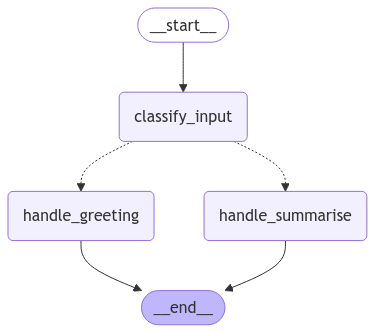

In [10]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [11]:
# run the graph
inputs = {"question":"hello, how are you?"}
result = app.invoke(inputs)
print(result)


<class 'str'>
{'question': 'hello, how are you?', 'classification': 'greeting', 'response': 'Hello! How can I help you!'}


In [12]:
# run the graph - 2
text_filename = "polar-bear-naming.txt"
with open(text_filename, "r", encoding="utf-8") as f:
    input_text = f.read()
final_input_text = "summarise the following context - " + input_text

inputs = {"question": final_input_text}
result = app.invoke(inputs)
print(result)

<class 'str'>


/Users/shreeya/Documents/Projects/Environments/GenAIVenvNew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


{'question': 'summarise the following context - The polar bear was given its common name by Thomas Pennant in A Synopsis of Quadrupeds (1771). It was known as the "white bear" in Europe between the 13th and 18th centuries, as well as "ice bear", "sea bear" and "Greenland bear". The Norse referred to it as isbjørn \'ice bear\' and hvitebjørn \'white bear\'. The bear is called nanook by the Inuit. The Netsilik cultures additionally have different names for bears based on certain factors, such as sex and age: these include adult males (anguraq), single adult females (tattaq), gestating females (arnaluk), newborns (hagliaqtug), large adolescents (namiaq) and dormant bears (apitiliit).[5] The scientific name Ursus maritimus is Latin for \'sea bear\'.[6][7]', 'classification': 'question', 'response': {'summarised_text': [{'summary_text': 'the polar bear was given its common name by Thomas Pennant in a Synopsis of Quadrupeds (1771) it was known as the "white bear" in Europe between the 13th a

In [17]:
# !python -m pip install protobuf
# !python -m pip install tiktoken

In [15]:
print(result["response"])

{'summarised_text': [{'summary_text': 'the polar bear was given its common name by Thomas Pennant in a Synopsis of Quadrupeds (1771) it was known as the "white bear" in Europe between the 13th and 18th centuries, as well as "ice bear", "sea bear" and "greenland bear" it is called nanook by the Inuit .'}]}
